# K-Nearest Neighbor(KNN) 
KNN算法：
- 训练阶段，分类器获取数据集并且简单的记住数据
- 测试阶段，分类器比较测试样本和所有训练样本，标签设定为k个最进训练样本的标签
- k通过交叉检验

In [1]:
# 路径配置
import os
import sys
PROJECT_PATH = os.path.dirname(os.getcwd())
sys.path.append(PROJECT_PATH)

In [2]:
# Run some setup code for this notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
# 导入原始的CIFAR-10数据
cifar10_dir = '/data/cifar-10-batches-py/'
X_train,y_train,X_test,y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ',X_train.shape)
print('Training labels shape: ',y_train.shape)
print('Test data shape: ',X_test.shape)
print('Test labels shape: ',y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


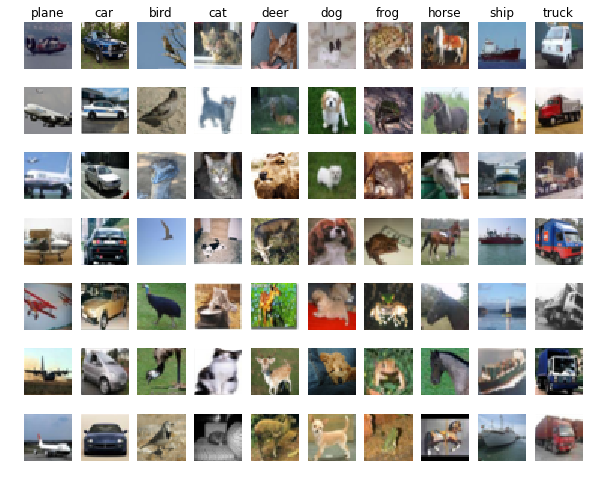

In [4]:
# 可视化一些样本
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 7
for y,cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class,replace=False)
    for i,idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class,num_classes,plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0 :
            plt.title(cls)
plt.show()

In [5]:
# Subampleing the data for efficient
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test = np.reshape(X_test,(X_test.shape[0],-1))
print(X_train.shape,X_test.shape)

(5000, 3072) (500, 3072)


In [7]:
from scripts.k_nearest_neighbor import KNearestNeighbor

# 创建KNN分类器的实例
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

In [8]:
# 测试KNN的实现
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


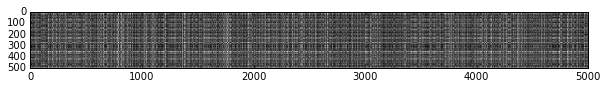

In [9]:
plt.imshow(dists,interpolation='none')
plt.show()

In [10]:
#预测
y_test_pred = classifier.predict_labels(dists,k=1)

#计算和打印出准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy:%f'%(num_correct,num_test,accuracy))

Got 137 / 500 correct => accuracy:0.274000


You should expect to see approximately 27% accuracy. Now lets try out a larger k, say k = 5:

In [11]:
y_test_pred = classifier.predict_labels(dists, k=10)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


In [12]:
dists_one = classifier.compute_distances_one_loops(X_test)
difference = np.linalg.norm(dists-dists_one,ord='fro') 
#相当于把矩阵转换为向量，然后计算其欧式距离
print("Difference was : %f"%(difference))
if difference < 0.0001:
    print("Good!")
else:
    print("Uh-oh!The distance matrices are difference")

Difference was : 0.000000
Good!


In [13]:
# 比较时间
def time_functions(f,*args):
    '''
    Call a function f with args and return the time that it took to execute
    '''
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_functions(classifier.compute_distances_two_loops,X_test)
print("Two loop version took %f seconds"%two_loop_time)

one_loop_time = time_functions(classifier.compute_distances_one_loops,X_test)
print("One loop version took %f seconds"%one_loop_time)

no_loop_time = time_functions(classifier.compute_distances_no_loops,X_test)
print("No loop version took %f seconds"%no_loop_time)

Two loop version took 23.511785 seconds
One loop version took 31.491575 seconds
No loop version took 0.193131 seconds


## Cross-validation

In [18]:
from sklearn.cross_validation import KFold
from sklearn.metrics import

In [33]:
num_folds = 5
k_choices = [1,3,5,8,10,12,15,20,50,100]

k_to_accuracies ={}
for k in k_choices:
    kfold = KFold(X_train.shape[0],n_folds=num_folds)
    accs = []
    for train,valida in kfold:
        Xtrain,ytrain,Xvalida,yvalida = X_train[train],y_train[train],X_train[valida],y_train[valida]
        cls = KNearestNeighbor()
        cls.train(Xtrain,ytrain)
        dists = cls.compute_distances_no_loops(Xvalida)
        ypred = cls.predict_labels(dists, k=k)
        acc = accuracy_score(ypred,yvalida)
        accs.append(acc)
    k_to_accuracies[k] = accs

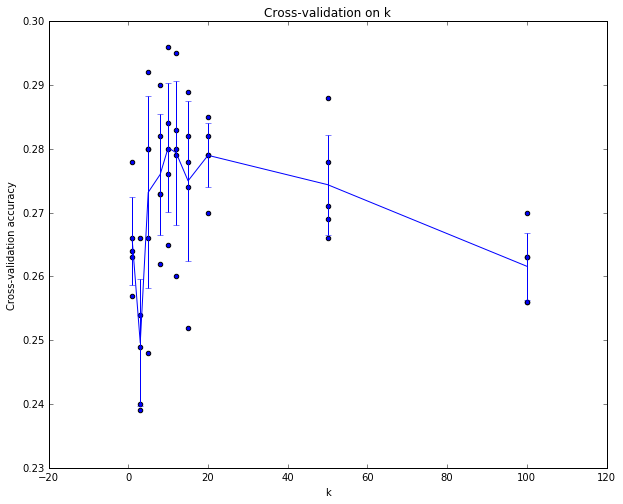

In [34]:
# polt the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k]*len(accuracies),accuracies)
    
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices,accuracies_mean,yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [35]:
best_k = 15

classifier = KNearestNeighbor()
classifier.train(X_train,y_train)
y_test_pred = classifier.predict(X_test,k=best_k)
accuracy = accuracy_score(y_test_pred,y_test)
accuracy

0.27200000000000002